In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F

import sys
import numpy as np
import pandas as pd
from umap.umap_ import UMAP
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

sys.path.append("../")
from helpers import plot_ts_cluster_results

Importing plotly failed. Interactive plots will not work.


In [2]:
df = pd.read_parquet(r"..\creds and datasets\sample_10_000_preprocessed.parquet")

In [3]:
df.columns = ['uid','usage']

In [4]:
df.head()

,uid,usage
2020-06-01,2860,0
2020-06-01,5126,0
2020-06-01,9047,0
2020-06-01,9900,114
2020-06-01,2406,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5790000 entries, 2020-06-01 to 2021-12-31
Data columns (total 2 columns):
 #   Column  Dtype
---  ------  -----
 0   uid     int16
 1   usage   int32
dtypes: int16(1), int32(1)
memory usage: 77.3 MB


In [6]:
train = df.pivot_table(index='uid',columns=df.index,values='usage')
train.columns = range(len(train.columns))
train.index.name = None
train.head()

,0,1,2,3,4,5,6,7,8,9,...,569,570,571,572,573,574,575,576,577,578
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,255,0,0,0,0,0,176,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1100,1726,1243,1426,1366,1215,859,1772,0,1099
3,0,0,0,0,0,0,0,0,0,0,...,341,647,634,46,32,284,374,451,0,1006
4,0,0,0,0,0,0,0,0,0,0,...,304,0,323,88,22,295,413,392,0,114


In [7]:
train = train.apply(lambda x:x/max(x),axis=1)

In [8]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,569,570,571,572,573,574,575,576,577,578
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.064378,0.000000,0.000000,0.000000,0.000000,0.000000,0.044433,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.193594,0.303766,0.218761,0.250968,0.240408,0.213833,0.151179,0.311862,0.0,0.193418
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.060925,0.115598,0.113275,0.008219,0.005717,0.050741,0.066822,0.080579,0.0,0.179739
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.060198,0.000000,0.063960,0.017426,0.004356,0.058416,0.081782,0.077624,0.0,0.022574


In [9]:
dataT = torch.tensor(train.values).float()

Let's create denoicing auto encoder for above dataset. Since auto encoder tring to construct original dataset from some fewer dimention, we can assume that lower dimention(latent or code layer) is compressed version for given datset. Hence we can use DAE as dimentinality reduction technique.

In [10]:
def createDAE():

  class aenet(nn.Module):
    def __init__(self):
      super().__init__()
      self.input = nn.Linear(579,150)
      self.enc = nn.Linear(150,15)
      self.lat = nn.Linear(15,150)
      self.dec = nn.Linear(150,579)

    def forward(self,x):
      x = F.relu( self.input(x))

      codex = F.relu(self.enc(x))
      
      x = F.relu(self.lat(codex))
      y = torch.sigmoid(self.dec(x))
      return y,codex

  net = aenet()

  lossfun = nn.MSELoss()
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)
  return net,lossfun,optimizer

In [11]:
def train_model(numepochs=100):
  net,lossfun,optimizer = createDAE()

  losses = torch.zeros(numepochs)

  for epochi in range(numepochs):
    randomidx = np.random.choice(dataT.shape[0],size=32)
    X = dataT[randomidx,:]
    yHat = net(X)[0] 
    loss = lossfun(yHat,X)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses[epochi] = loss.item()

  return losses,net

Final loss: 0.0223


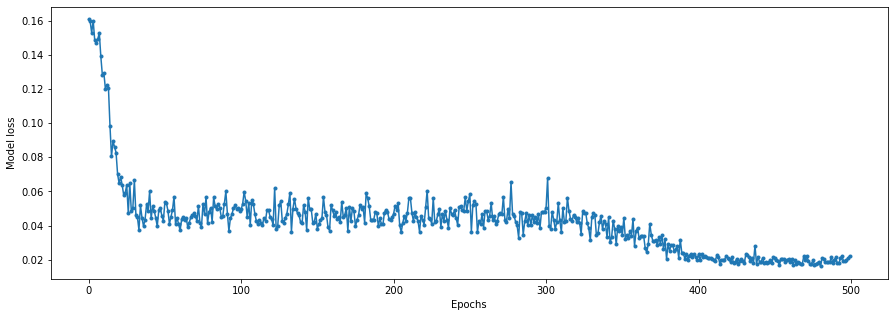

In [12]:
losses,net = train_model(numepochs=500)
print(f'Final loss: {losses[-1]:.4f}')

plt.figure(figsize=(15,5))
plt.plot(losses,'.-')
plt.xlabel('Epochs')
plt.ylabel('Model loss')
plt.show()

In [13]:
yHat,latent = net(dataT)
pcatrain= PCA(n_components=15).fit(train)
pcalatent = PCA().fit(latent.detach())

In [14]:
scoresData = pcatrain.fit_transform(train)
scoresCode = pcalatent.fit_transform(latent.detach())

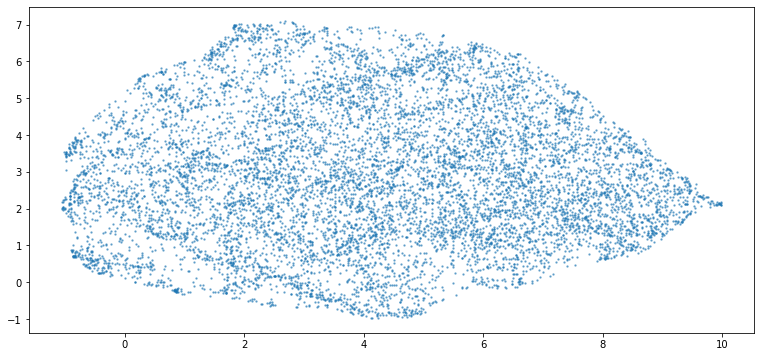

In [15]:
clusterable_embedding = UMAP(
    n_components=2,
    random_state=42,
).fit_transform(scoresData)

plt.figure(figsize=(13,6))
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],s=2, cmap='viridis',alpha=0.5)
plt.show()

Let's try to build clustering model using latent dataset.

In [16]:
model = KMeans(n_clusters=5)
clusters = model.fit_predict(scoresCode)

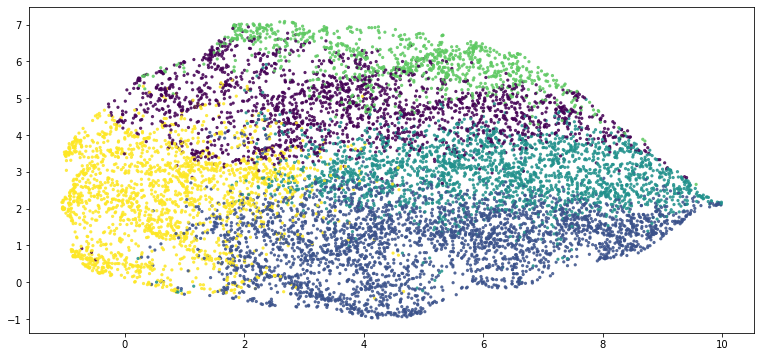

In [17]:
plt.figure(figsize=(13,6))
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],c=clusters,s=5, cmap='viridis',alpha=0.8)
plt.show()

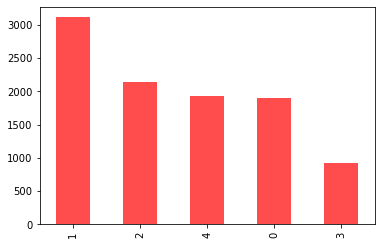

In [18]:
train['segment'] = clusters
ax = train['segment'].value_counts().plot.bar(color='r',alpha=0.7)
plt.show()

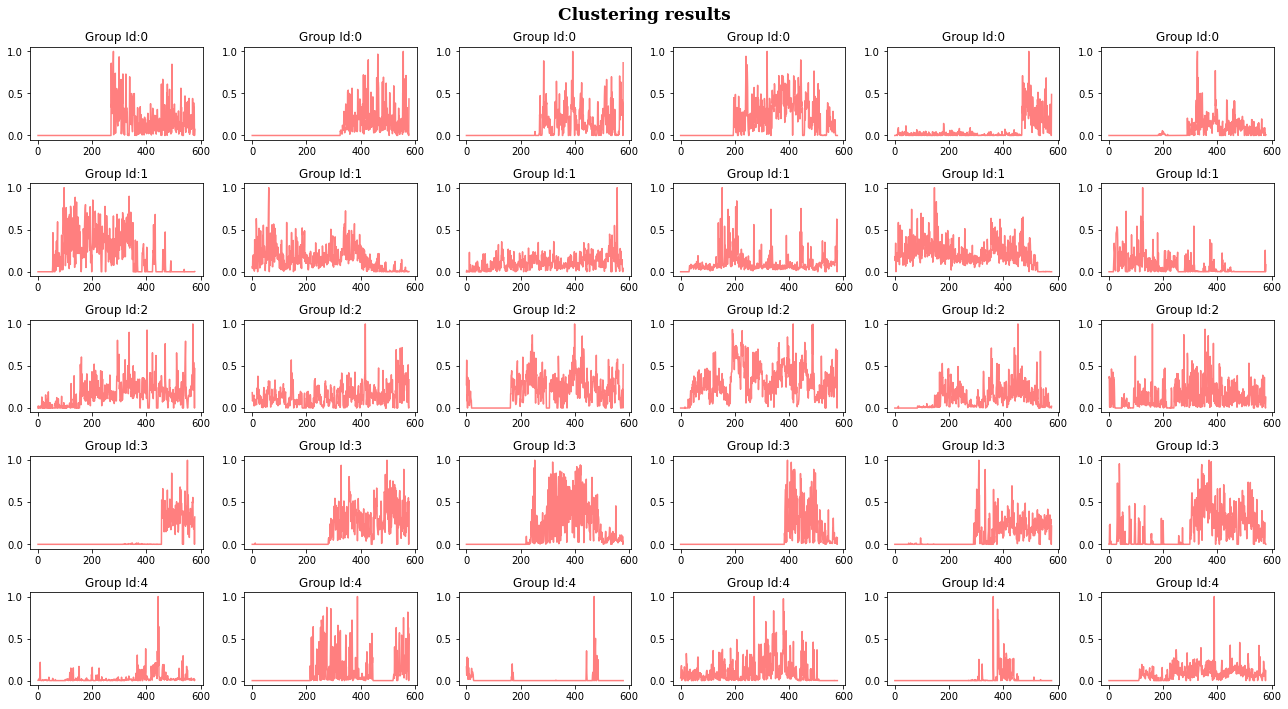

In [19]:
n = 6
fig,ax = plt.subplots(len(np.unique(clusters)),n,figsize=(18,10))

u00 = train.query("segment==0")[range(579)].sample(n).values
u01 = train.query("segment==1")[range(579)].sample(n).values
u02 = train.query("segment==2")[range(579)].sample(n).values
u03 = train.query("segment==3")[range(579)].sample(n).values
u04 = train.query("segment==4")[range(579)].sample(n).values

for i,g in enumerate([u00,u01,u02,u03,u04]):
    for j,usage in enumerate(g):
        ax[i][j].set_title(f"Group Id:{i}")
        ax[i][j].plot(usage,color='r',alpha=0.5)

fig.suptitle('Clustering results',fontfamily='serif',fontsize='17',fontweight='semibold')
plt.tight_layout()
plt.show()

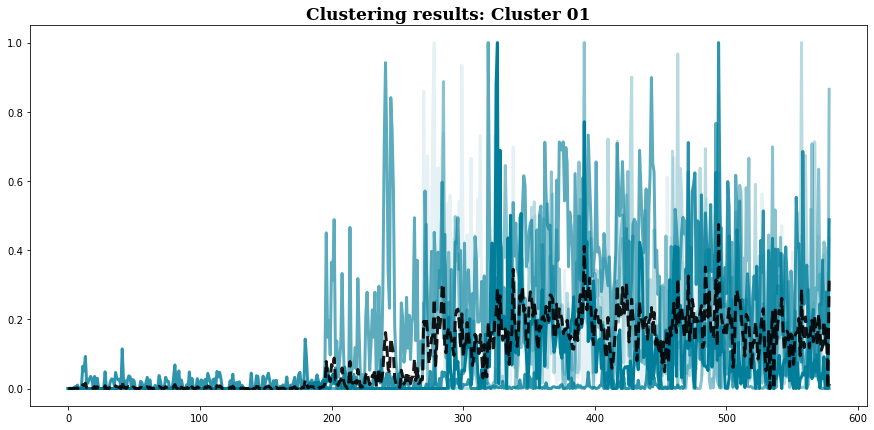

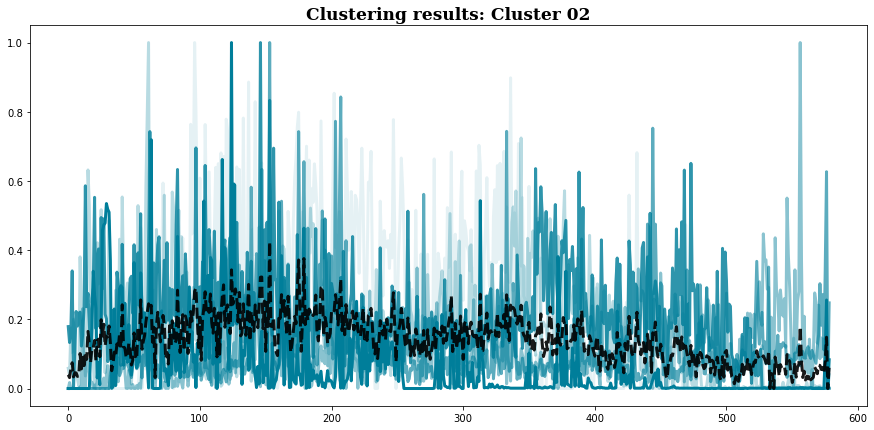

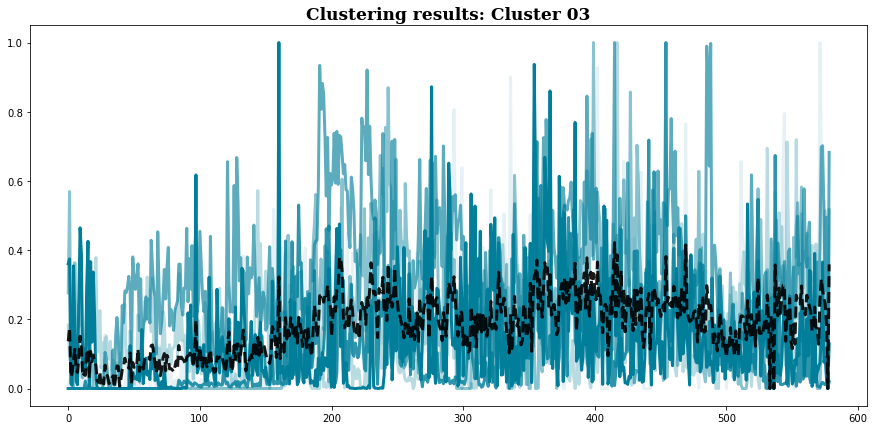

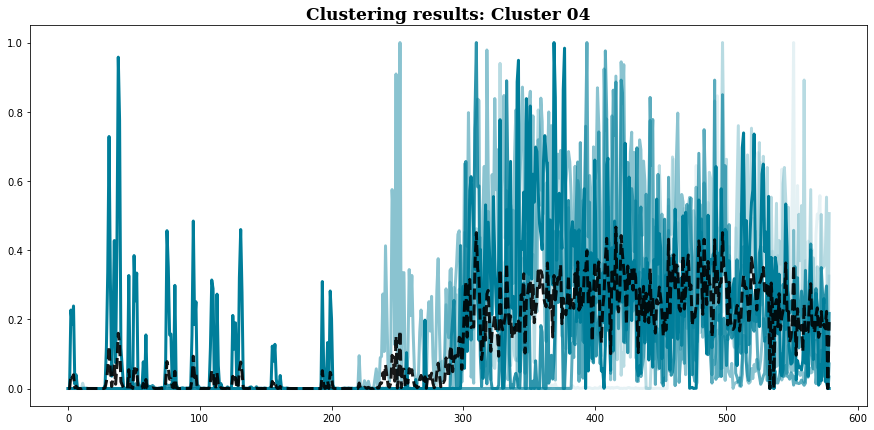

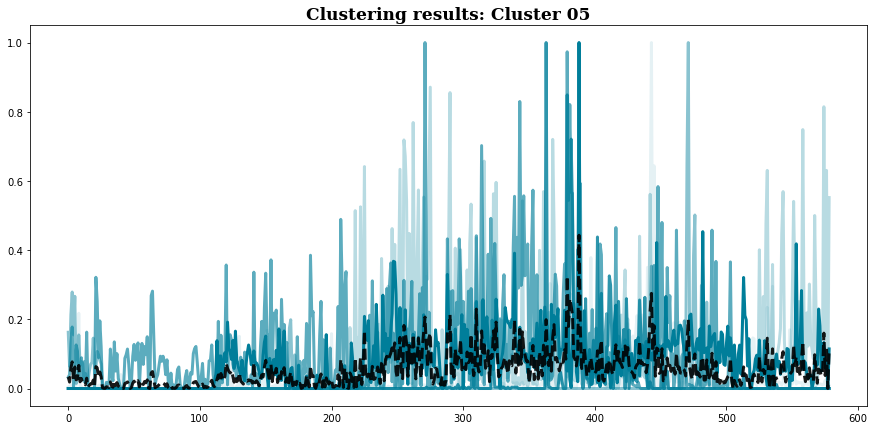

In [20]:
for i,g in enumerate([u00,u01,u02,u03,u04]):
    plot_ts_cluster_results(g,i,n=n,plot_mean=True)

Even the method used here is more likely to general clustering method, our resuls seems reasonable. In next notebook, we will use some time series specific clustering method called **DTW** $(Dynamin\space Time\space Warping)$

<img src='https://miro.medium.com/max/1360/1*uFicSZjqkNBfsyrsJw7J9g.jpeg'>